In [99]:
import pandas, scipy, numpy, seaborn
import matplotlib, matplotlib.pyplot as plt
from scipy.stats import pearsonr

In [3]:
matplotlib.rcParams.update({'font.size':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 
                            'axes.grid' : True, 'grid.alpha': 0.5, 'grid.linestyle' : ':',
                            'figure.figsize':(8, 5), 'svg.fonttype' : 'none'})

In [11]:
file_directory = "/Users/kja11/OneDrive - Menntaský (1)/Mild_Hypothermia_project/in_silico/Python/"

In [12]:
path = "1) input/RNAseq/"

# II] Data Download

In [55]:
#data all_counts_filtered
df_count = pandas.read_csv(file_directory+path+ 'transcript_HEK293_temp_all_counts_unfiltered.tsv',
                     sep = '\t')
print(df.shape)
df_count.head()

(135603, 9)


,gene_id,gene_name,feature_id,s37rep2,s32rep3,s37rep1,s37rep3,s32rep1,s32rep2
0,ENSG00000198034,RPS4X,ENST00000316084,232646,199874,190685,196125,160799,177622
1,ENSG00000142937,RPS8,ENST00000396651,191357,163277,156765,160123,133777,150626
2,ENSG00000182774,RPS17,ENST00000647841,188996,163258,157911,153051,133896,156007
3,ENSG00000229117,RPL41,ENST00000546591,182501,170503,142081,168055,126151,146154
4,ENSG00000142937,RPS8,ENST00000485390,182336,155347,148909,154214,126332,142296


In [56]:
#Transform to TPM ?
df_count = df_count.assign(mean_32C = (df_count[['s37rep1', 's37rep2', 's37rep3']].mean(axis=1).round(0)),
                           mean_37C = (df_count[['s32rep1', 's32rep2', 's32rep3']].mean(axis=1).round(0))) 

df_count.rename(columns={df.columns[2]: 'transcript_id'},inplace=True)
# df_count.set_index('transcript_id', inplace = True, drop = True )
df_count = df_count[['transcript_id','gene_name', 'mean_37C', 'mean_32C']]
print(len(df_count))
df_count.head()

135603


,transcript_id,gene_name,mean_37C,mean_32C
0,ENST00000316084,RPS4X,179432.0,206485.0
1,ENST00000396651,RPS8,149227.0,169415.0
2,ENST00000647841,RPS17,151054.0,166653.0
3,ENST00000546591,RPL41,147603.0,164212.0
4,ENST00000485390,RPS8,141325.0,161820.0


In [60]:
%%time
#data DETseq HEK293 
df_gtf = pandas.read_csv(file_directory+path+ '20240216_mytranscripts.gtf',
                               sep = '\t', comment='#', header=None)
print(df_gtf.shape)

df_gtf.columns = ["seqname", "source", "feature", "start", "end",
                  "score", "strand", "frame", "attribute"]
df_gtf.head()

<timed exec>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


(2704200, 9)
CPU times: total: 5.64 s
Wall time: 16.7 s


,seqname,source,feature,start,end,score,strand,frame,attribute
0,1,havana,transcript,3069168,3434342,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."
1,1,havana,exon,3069168,3069296,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."
2,1,havana,CDS,3069260,3069296,.,+,0,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."
3,1,havana,start_codon,3069260,3069262,.,+,0,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."
4,1,havana,exon,3186125,3186474,.,+,.,"gene_id ""ENSG00000142611""; gene_version ""17""; ..."


In [61]:
# Only select full transcripts
df_gtf = df_gtf[df_gtf["feature"] == "transcript"]
# extract ID
df_gtf['transcript_id'] = df_gtf['attribute'].str.extract('transcript_id "([^"]+)"')
# Calculate size
df_gtf['transcript_length'] = df_gtf['end'] - df_gtf['start'] + 1

# df_gtf.set_index('transcript_id', inplace = True, drop = True )
df_gtf = df_gtf[['transcript_id', 'transcript_length']]
df_gtf

,transcript_id,transcript_length
0,ENST00000511072,365175
37,ENST00000378391,366225
76,ENST00000514189,365132
113,ENST00000270722,369419
152,ENST00000512462,195995
...,...,...
2704146,ENST00000707304,14213
2704165,ENST00000707305,14219
2704184,ENST00000707306,970
2704189,ENST00000631997,6385


In [62]:
df_count.head(1)

,transcript_id,gene_name,mean_37C,mean_32C
0,ENST00000316084,RPS4X,179432.0,206485.0


In [63]:
df_gtf.head(1)

,transcript_id,transcript_length
0,ENST00000511072,365175


In [64]:
# df with gene name
df_plot = df_count.merge(df_gtf)
print(f'We lost {len(df_gtf) - len(df_count)} transcripts')

df_plot.head()

In [68]:
print({len(df_gtf)} - {len(df_count)})
df_plot

{146122}


,transcript_id,gene_name,mean_37C,mean_32C,transcript_length
0,ENST00000316084,RPS4X,179432.0,206485.0,5207
1,ENST00000396651,RPS8,149227.0,169415.0,3240
2,ENST00000647841,RPS17,151054.0,166653.0,3708
3,ENST00000546591,RPL41,147603.0,164212.0,1335
4,ENST00000485390,RPS8,141325.0,161820.0,3144
...,...,...,...,...,...
135598,ENST00000535492,RAP1B,0.0,0.0,46211
135599,ENST00000544639,RAP1B,0.0,0.0,6170
135600,ENST00000458499,VGLL4,0.0,0.0,68056
135601,ENST00000699630,NLRP1,0.0,0.0,84889


In [147]:
df_nonzero

,transcript_id,gene_name,mean_37C,mean_32C,transcript_length,ratio_37C,ratio_32C
0,ENST00000316084,RPS4X,179432.0,206485.0,5207,34.459766,39.655272
1,ENST00000396651,RPS8,149227.0,169415.0,3240,46.057716,52.288580
2,ENST00000647841,RPS17,151054.0,166653.0,3708,40.737325,44.944175
3,ENST00000546591,RPL41,147603.0,164212.0,1335,110.564045,123.005243
4,ENST00000485390,RPS8,141325.0,161820.0,3144,44.950700,51.469466
...,...,...,...,...,...,...,...
134140,ENST00000524072,ANKRD46,1.0,0.0,30002,0.000033,0.000000
134141,ENST00000598934,CCDC200,1.0,0.0,3035,0.000329,0.000000
134142,ENST00000594691,CCDC200,1.0,0.0,81828,0.000012,0.000000
134143,ENST00000636331,CCDC200,1.0,0.0,7204,0.000139,0.000000


(array([1.0598e+05, 3.3000e+02, 9.9000e+01, 5.4000e+01, 4.6000e+01,
        2.8000e+01, 2.7000e+01, 3.5000e+01, 2.4000e+01, 3.1000e+01,
        2.1000e+01, 1.4000e+01, 1.6000e+01, 2.0000e+01, 2.0000e+01,
        1.3000e+01, 1.2000e+01, 6.0000e+00, 3.0000e+00, 7.0000e+00,
        3.0000e+00, 2.0000e+00, 3.0000e+00, 1.0000e+00, 3.0000e+00,
        1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([1.00000000e+00, 5.98203333e+03, 1.19630667e+04, 1.79441000e+04,
        2.39251333e+04, 2.99061667e+04, 3.58872000e+04, 4.18682333e+04,
        4.78492667e+04, 5.38303000e+04, 5.98113333e+04, 6.57923667e+04,
        7.17734000e+04, 7.77544333e+04, 8.37354667e+04, 8.97165000e+04,
        9.56975333e+04, 1.01678567e+05, 1.07659600e+05, 1.13640633e+05,
        1.19621667e+05, 1.25602700e+05, 1.31583733e+05, 1.37564767e+05,
        1.43545800e+05, 1.49526833e+05, 1.55507867e+05, 1.61488900e+05,
        1.67469933e+05, 1.73450967e+05, 1.79432000e+05]),
 <BarContainer object of 30 

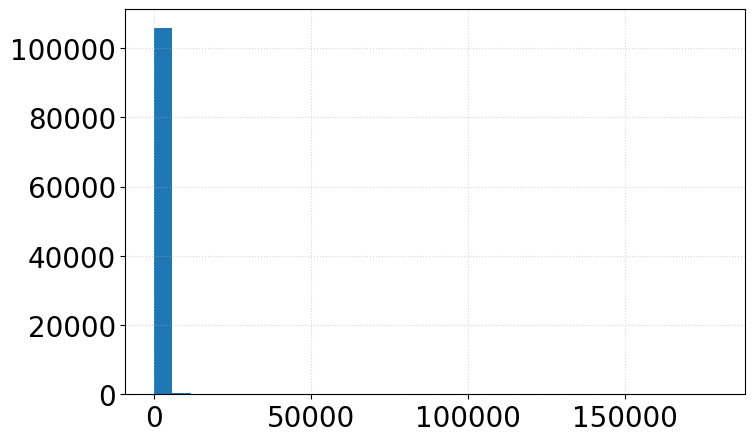

In [146]:
df_nonzero = df_plot[df_plot.mean_37C > 0]
plt.hist(df_nonzero.mean_37C, bins=30)

In [141]:
print(df_plot.mean_37C.describe())

count    135603.000000
mean        269.415551
std        3469.002231
min           0.000000
25%           1.000000
50%           4.000000
75%          30.000000
max      179432.000000
Name: mean_37C, dtype: float64


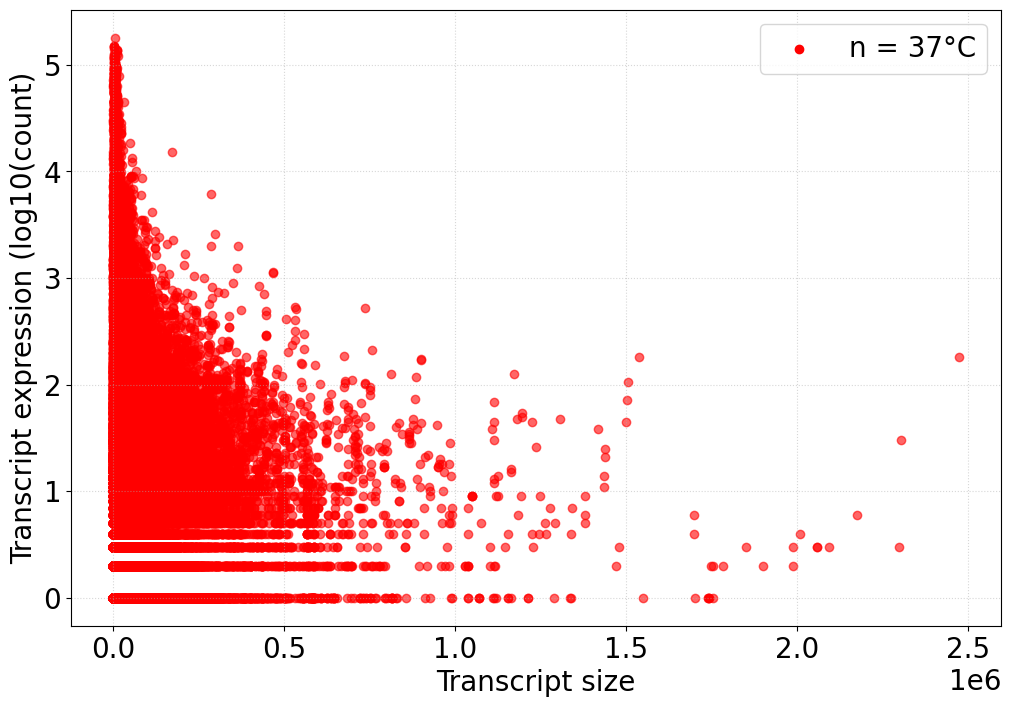

In [137]:
expr_37 = df_plot.mean_37C.apply(numpy.log10)
expr_32 = df_plot.mean_32C.apply(numpy.log10)
size = df_plot.transcript_length

plt.figure(figsize=(12, 8))
plt.scatter(y = expr_37, x = size, alpha = 0.6, color = 'red')
plt.scatter(x=[],y=[], marker="o", color='red', label= f'n = 37°C')

plt.xlabel('Transcript size')
plt.ylabel('Transcript expression log10(count)')
plt.legend()

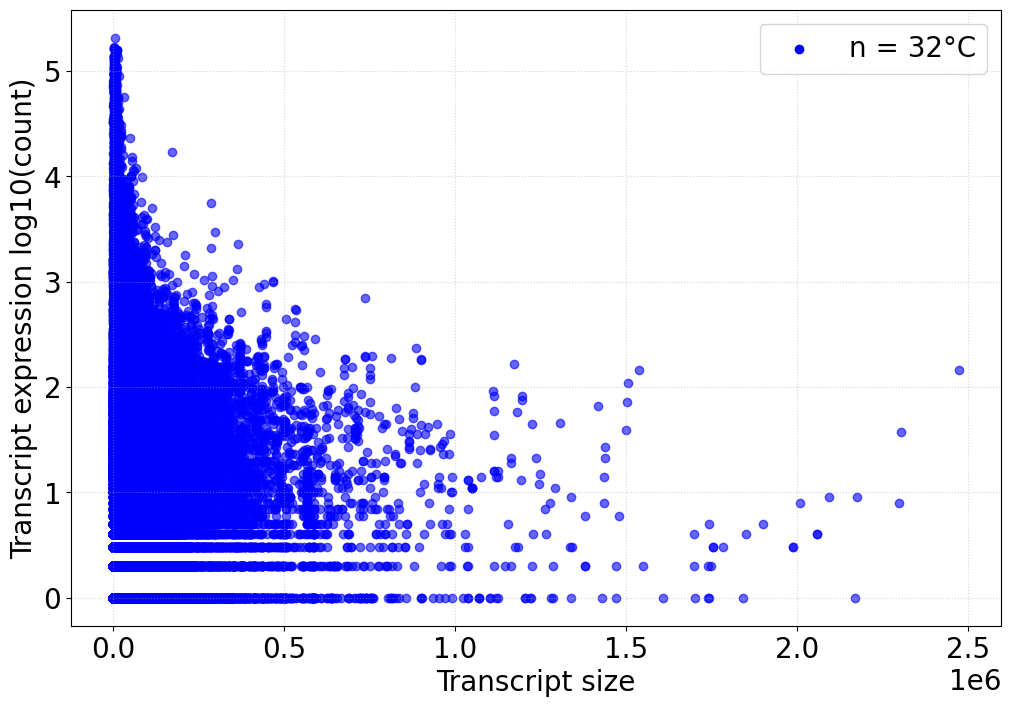

In [139]:
plt.figure(figsize=(12, 8))
plt.scatter(y = expr_32, x = size, alpha = 0.6, color = 'blue')
plt.scatter(x=[],y=[], marker="o", color='blue', label= f'n = 32°C')

plt.xlabel('Transcript size')
plt.ylabel('Transcript expression log10(count)')
plt.legend()

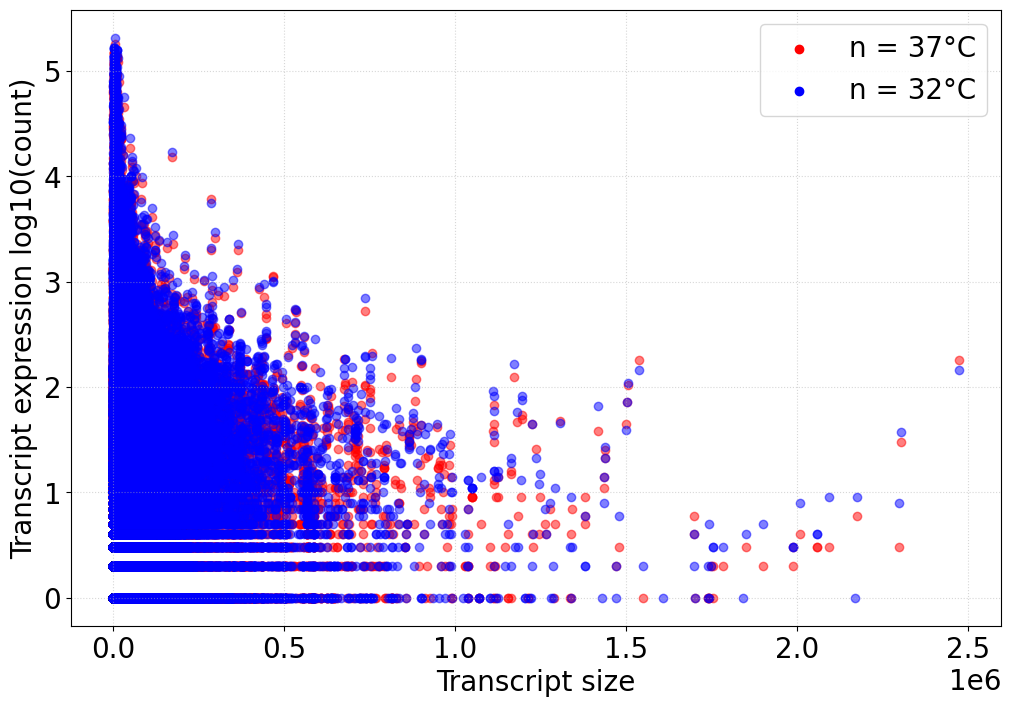

In [138]:
plt.figure(figsize=(12, 8))
plt.scatter(y = expr_37, x = size, alpha = 0.5, color = 'red')
plt.scatter(y = expr_32, x = size, alpha = 0.5, color = 'blue')

plt.scatter(x=[],y=[], marker="o", color='red', label= f'n = 37°C')
plt.scatter(x=[],y=[], marker="o", color='blue', label= f'n = 32°C')

plt.xlabel('Transcript size')
plt.ylabel('Transcript expression log10(count)')
plt.legend()

In [98]:
df_plot.head()
df_plot = df_plot.assign(ratio_37C = df_plot['mean_37C'] / df_plot['transcript_length'],
                         ratio_32C = df_plot['mean_32C'] / df_plot['transcript_length'])
df_plot.head()

,transcript_id,gene_name,mean_37C,mean_32C,transcript_length,ratio_37C,ratio_32C
0,ENST00000316084,RPS4X,179432.0,206485.0,5207,34.459766,39.655272
1,ENST00000396651,RPS8,149227.0,169415.0,3240,46.057716,52.288580
2,ENST00000647841,RPS17,151054.0,166653.0,3708,40.737325,44.944175
3,ENST00000546591,RPL41,147603.0,164212.0,1335,110.564045,123.005243
4,ENST00000485390,RPS8,141325.0,161820.0,3144,44.950700,51.469466


Pearson corr score is: 0.9978989519578566, 0.0
Spearman corr score is: 0.8697744449483259, 0.0


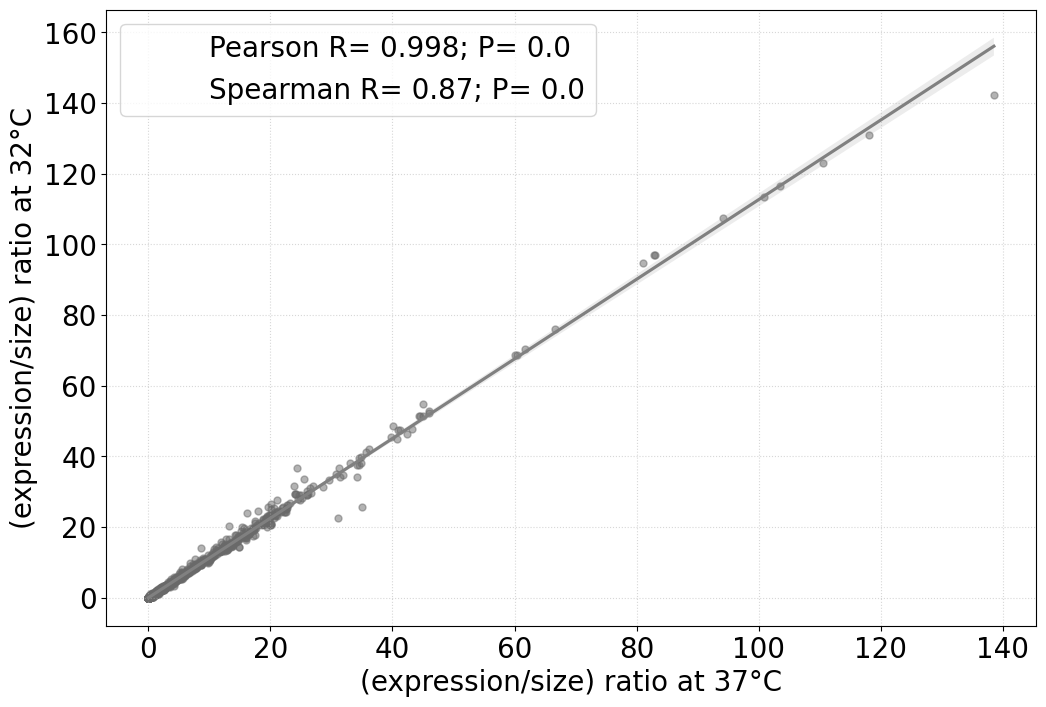

In [136]:
# Calculate correlation score
df_plot = df_plot.assign(ratio_37C = df_plot['mean_37C'] / df_plot['transcript_length'],
                         ratio_32C = df_plot['mean_32C'] / df_plot['transcript_length'])


x= df_plot.ratio_37C
y= df_plot.ratio_32C

#stat Pearson correlation score 
r_value_pcs, p_value_pcs = scipy.stats.pearsonr(x, y)
print(f'Pearson corr score is: {r_value_pcs}, {p_value_pcs}')

#stat Spearman correlation score 
r_value_scs, p_value_scs = scipy.stats.spearmanr(x, y)
print(f'Spearman corr score is: {r_value_scs}, {p_value_scs}')

#graph
plt.figure(figsize=(12, 8))
seaborn.regplot(x=x,y=y, x_ci = 0, marker=".",
                scatter_kws={"color": "dimgrey", "alpha": 0.5, 's': 100}, line_kws={"color": "grey"})

seaborn.regplot(x=[],y=[], marker=" ", 
                label= f'Pearson R= {str(round(r_value_pcs,3))}; P= {str(round(p_value_pcs,3))}')

seaborn.regplot(x=[],y=[], marker=" ", 
                label= f'Spearman R= {str(round(r_value_scs,3))}; P= {str(round(p_value_scs,3))}')

plt.xlabel("(expression/size) ratio at 37°C")
plt.ylabel('(expression/size) ratio at 32°C')

plt.legend()

plt.show()  